📦 Installing required packages...
✅ Packages installed successfully!

📊 LOADING AMAZON POLARITY DATASET
Loading train and test splits...
✓ Train samples: 20,000
✓ Test samples: 5,000

Example review:
  Label: Negative
  Text: All the pretty people in this film. Even the Rudy character played by Michael Madsen. This is adapted from a Jim Thompson novel for cryin' out loud! These are supposed to be marginal characters, not f...

🤖 LOADING FLAN-T5-SMALL MODEL
Model: google/flan-t5-small (80M parameters)
Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB

🔧 PREPROCESSING DATA
Tokenizing training data...
Tokenizing test data...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

✓ Preprocessing complete!

🎯 TRAINING CONFIGURATION
✓ Epochs: 3
✓ Batch size: 16
✓ Learning rate: 0.0003
✓ FP16 training: False

🏋️ TRAINING MODEL
This will take approximately 20-30 minutes on free Colab T4 GPU...



/tmp/ipython-input-1230744129.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.027500,0.022476
2,0.017600,0.022617
3,0.010000,0.024968


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



✅ Training completed in 20.64 minutes!
Final training loss: 0.4963

📈 TRAINING LOSS CURVE


/tmp/ipython-input-1230744129.py:211: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


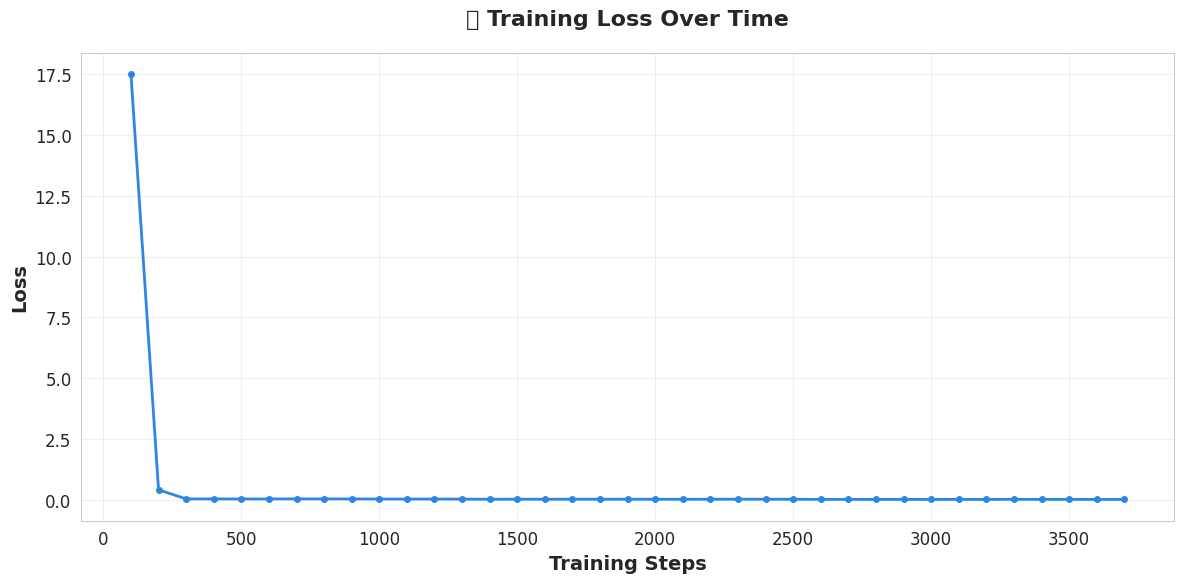

Starting loss: 17.5145
Final loss: 0.0100
Loss reduction: 99.9%

🧪 EVALUATING ON TEST SET
Generating predictions...


  0%|          | 0/157 [00:00<?, ?it/s]


📊 TEST SET RESULTS
✓ Accuracy:  0.9308 (93.08%)
✓ F1-Score:  0.9331
✓ Avg Inference Time: 4.83 ms per review

🎨 CONFUSION MATRIX


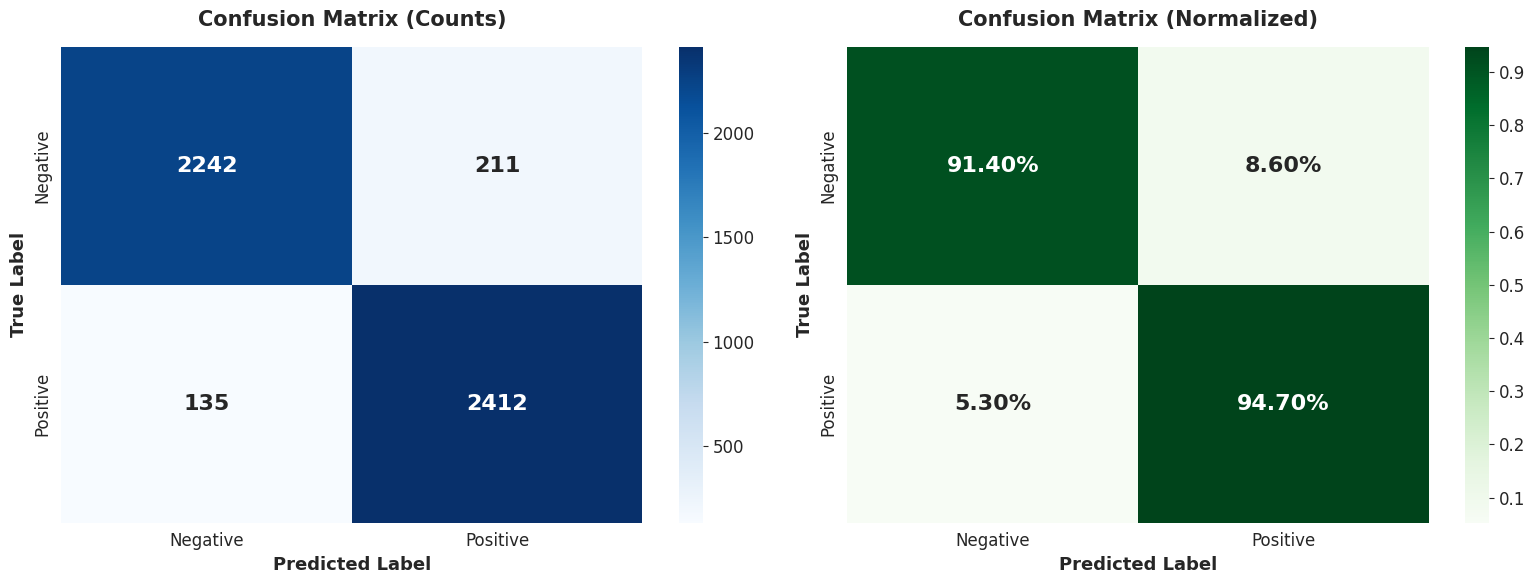


True Negatives:  2,242
False Positives: 211
False Negatives: 135
True Positives:  2,412

🎭 EXAMPLE PREDICTIONS


✅ Example 1
   Text: What matters is using the cable with the highest capability your gear will support (HDMI, DVI, component), and using a decent quality shielded cable. But don't waste your money on "features" that won'...
   True: Negative | Predicted: Negative
------------------------------------------------------------
✅ Example 2
   Text: Being desperate for ideas as to what to make my 13 year old son who is on a Candida Diet, I thought I had found a gold mine on discovering this book. I was disappointed, however, when I checked with m...
   True: Negative | Predicted: Negative
------------------------------------------------------------
✅ Example 3
   Text: I have become a fast fan of Mustela products for my 3 year old who suffers from eczema. This is the first Mustella product that fell short for me. I started with bath oils, shampoo & conditioner, mass...
   True: 

In [4]:
# ==========================================
# 🚀 FLAN-T5 Sentiment Analysis on Amazon Reviews
# ==========================================
# Fine-tuning google/flan-t5-small (80M params) on amazon_polarity dataset
# Optimized for FREE Google Colab (T4 GPU + High RAM)
# Expected runtime: 20-30 minutes
# ==========================================

print("📦 Installing required packages...")
!pip install -q transformers datasets accelerate evaluate seaborn scikit-learn sentencepiece

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import evaluate

# Set style for beautiful plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✅ Packages installed successfully!\n")

# ==========================================
# 📊 STEP 1: Load and Prepare Dataset
# ==========================================
print("=" * 60)
print("📊 LOADING AMAZON POLARITY DATASET")
print("=" * 60)

# Load dataset (we'll use a subset for faster training on free Colab)
print("Loading train and test splits...")
dataset = load_dataset("amazon_polarity")

# Use a smaller subset for free Colab (20k train, 5k test)
train_dataset = dataset["train"].shuffle(seed=42).select(range(20000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(5000))

print(f"✓ Train samples: {len(train_dataset):,}")
print(f"✓ Test samples: {len(test_dataset):,}")
print(f"\nExample review:")
print(f"  Label: {'Positive' if train_dataset[0]['label'] == 1 else 'Negative'}")
print(f"  Text: {train_dataset[0]['content'][:200]}...\n")

# ==========================================
# 🤖 STEP 2: Load Model and Tokenizer
# ==========================================
print("=" * 60)
print("🤖 LOADING FLAN-T5-SMALL MODEL")
print("=" * 60)

model_name = "google/flan-t5-small"
print(f"Model: {model_name} (80M parameters)")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")

# ==========================================
# 🔧 STEP 3: Preprocessing Function
# ==========================================
print("=" * 60)
print("🔧 PREPROCESSING DATA")
print("=" * 60)

# FLAN-T5 uses text-to-text format
# Input: "classify sentiment: [review text]"
# Output: "positive" or "negative"

def preprocess_function(examples):
    # Create input prompts
    inputs = ["classify sentiment: " + text for text in examples["content"]]

    # Create target labels
    targets = ["positive" if label == 1 else "negative" for label in examples["label"]]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    # Tokenize targets
    labels = tokenizer(
        targets,
        max_length=8,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("Tokenizing training data...")
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

print("Tokenizing test data...")
tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_dataset.column_names
)

print("✓ Preprocessing complete!\n")

# ==========================================
# 🎯 STEP 4: Training Configuration
# ==========================================
print("=" * 60)
print("🎯 TRAINING CONFIGURATION")
print("=" * 60)

training_args = TrainingArguments(
    output_dir="./flan-t5-sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    warmup_steps=200,
    fp16=False,  # Disabled for T5 stability
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    push_to_hub=False,
    report_to="none",
    gradient_accumulation_steps=1,
    save_total_limit=2
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

print(f"✓ Epochs: {training_args.num_train_epochs}")
print(f"✓ Batch size: {training_args.per_device_train_batch_size}")
print(f"✓ Learning rate: {training_args.learning_rate}")
print(f"✓ FP16 training: {training_args.fp16}\n")

# ==========================================
# 🏋️ STEP 5: Train the Model
# ==========================================
print("=" * 60)
print("🏋️ TRAINING MODEL")
print("=" * 60)
print("This will take approximately 20-30 minutes on free Colab T4 GPU...\n")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train!
start_time = time.time()
train_result = trainer.train()
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes!")
print(f"Final training loss: {train_result.training_loss:.4f}\n")

# ==========================================
# 📈 STEP 6: Training Loss Curve
# ==========================================
print("=" * 60)
print("📈 TRAINING LOSS CURVE")
print("=" * 60)

# Extract loss history
log_history = trainer.state.log_history
train_losses = [log['loss'] for log in log_history if 'loss' in log]
steps = [log['step'] for log in log_history if 'loss' in log]

plt.figure(figsize=(12, 6))
plt.plot(steps, train_losses, linewidth=2, color='#2E86DE', marker='o', markersize=4)
plt.xlabel('Training Steps', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('📉 Training Loss Over Time', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Starting loss: {train_losses[0]:.4f}")
print(f"Final loss: {train_losses[-1]:.4f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%\n")

# ==========================================
# 🧪 STEP 7: Evaluate on Test Set
# ==========================================
print("=" * 60)
print("🧪 EVALUATING ON TEST SET")
print("=" * 60)

# Function to decode predictions
def decode_predictions(preds):
    decoded = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Map to binary labels
    labels = []
    for pred in decoded:
        pred_lower = pred.lower().strip()
        if "positive" in pred_lower:
            labels.append(1)
        elif "negative" in pred_lower:
            labels.append(0)
        else:
            labels.append(1)  # Default to positive if unclear
    return labels

# Get predictions
print("Generating predictions...")
model.eval()
all_preds = []
all_labels = []
inference_times = []

with torch.no_grad():
    for i in tqdm(range(0, len(test_dataset), 32)):
        batch = test_dataset[i:i+32]
        inputs = ["classify sentiment: " + text for text in batch["content"]]

        # Tokenize
        encoded = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=256)
        encoded = {k: v.to(device) for k, v in encoded.items()}

        # Time inference
        start = time.time()
        outputs = model.generate(**encoded, max_length=8)
        inference_times.append((time.time() - start) / len(batch["content"]))

        # Decode predictions
        preds = decode_predictions(outputs)
        all_preds.extend(preds)
        all_labels.extend(batch["label"])

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
avg_inference_time = np.mean(inference_times) * 1000  # Convert to ms

print("\n" + "=" * 60)
print("📊 TEST SET RESULTS")
print("=" * 60)
print(f"✓ Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"✓ F1-Score:  {f1:.4f}")
print(f"✓ Avg Inference Time: {avg_inference_time:.2f} ms per review")
print("=" * 60 + "\n")

# ==========================================
# 🎨 STEP 8: Confusion Matrix Heatmap
# ==========================================
print("=" * 60)
print("🎨 CONFUSION MATRIX")
print("=" * 60)

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax1,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={'size': 16, 'weight': 'bold'})
ax1.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax1.set_title('Confusion Matrix (Counts)', fontsize=15, fontweight='bold', pad=15)

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=True, ax=ax2,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={'size': 16, 'weight': 'bold'})
ax2.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=15, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}\n")

# ==========================================
# 🎭 STEP 9: Example Predictions
# ==========================================
print("=" * 60)
print("🎭 EXAMPLE PREDICTIONS")
print("=" * 60)

# Select diverse examples
example_indices = [10, 50, 100, 500, 1000]
examples = [test_dataset[i] for i in example_indices]

print("\n")
for i, example in enumerate(examples, 1):
    text = example["content"][:200] + "..." if len(example["content"]) > 200 else example["content"]
    true_label = "Positive" if example["label"] == 1 else "Negative"

    # Get prediction
    input_text = f"classify sentiment: {example['content']}"
    encoded = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=256).to(device)

    with torch.no_grad():
        output = model.generate(**encoded, max_length=8)

    pred_text = tokenizer.decode(output[0], skip_special_tokens=True)
    pred_label = "Positive" if "positive" in pred_text.lower() else "Negative"

    match_emoji = "✅" if pred_label == true_label else "❌"

    print(f"{match_emoji} Example {i}")
    print(f"   Text: {text}")
    print(f"   True: {true_label} | Predicted: {pred_label}")
    print("-" * 60)

# ==========================================
# 🎉 STEP 10: Final Summary
# ==========================================
print("\n" + "=" * 60)
print("🎉 TRAINING COMPLETE - SUMMARY")
print("=" * 60)
print(f"✓ Model: {model_name}")
print(f"✓ Training samples: {len(train_dataset):,}")
print(f"✓ Test samples: {len(test_dataset):,}")
print(f"✓ Training time: {training_time/60:.2f} minutes")
print(f"✓ Test Accuracy: {accuracy*100:.2f}%")
print(f"✓ Test F1-Score: {f1:.4f}")
print(f"✓ Avg Inference: {avg_inference_time:.2f} ms/review")
print("=" * 60)
print("\n🚀 Model ready for deployment!")
print("💾 Model saved to: ./flan-t5-sentiment")
print("\n📝 To load the model later:")
print("   from transformers import AutoTokenizer, AutoModelForSeq2SeqLM")
print("   tokenizer = AutoTokenizer.from_pretrained('./flan-t5-sentiment')")
print("   model = AutoModelForSeq2SeqLM.from_pretrained('./flan-t5-sentiment')")
print("=" * 60)